# Suffrage Debates Analysis

This notebook explores the suffrage-related speeches collected from UK Parliamentary debates.

## Dataset Overview
- **Total speeches**: 53,339 (from 1,221 debates)
- **Suffrage-related speeches**: 2,808 (HIGH: 1,485, MEDIUM: 1,323)
- **Date range**: April 1910 to October 1929
- **MP matching rate**: 89.1%

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set professional styling
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Professional color palette
COLORS = {
    'male': '#3B82C4',
    'female': '#EC4899',
    'background': '#FFFFFF',
    'grid': '#E5E7EB',
    'text': '#1F2937',
    'muted': '#9CA3AF',
    'accent1': '#10B981',
    'accent2': '#F59E0B',
}

## Load Data

In [47]:
# Load the main dataset
speeches_df = pd.read_parquet('../outputs/suffrage_debates/all_speeches_in_suffrage_debates.parquet')

# Load debate summaries
debates_df = pd.read_parquet('../outputs/suffrage_debates/debate_summary.parquet')

print(f"Loaded {len(speeches_df):,} speeches from {len(debates_df):,} debates")
print(f"\nColumns in speeches dataset: {list(speeches_df.columns)}")
print(f"\nColumns in debates dataset: {list(debates_df.columns)}")

Loaded 53,339 speeches from 1,221 debates

Columns in speeches dataset: ['speech_id', 'debate_id', 'file_path', 'sequence_number', 'speaker', 'normalized_speaker', 'canonical_name', 'person_id', 'gender', 'matched_mp', 'party', 'constituency', 'position', 'text', 'word_count', 'year', 'decade', 'month', 'date', 'chamber', 'title', 'topic', 'hansard_reference', 'reference_volume', 'reference_columns', 'is_suffrage_speech', 'suffrage_confidence']

Columns in debates dataset: ['debate_id', 'total_speeches', 'suffrage_speeches', 'unique_speakers', 'date', 'year', 'total_words', 'matched_speeches', 'suffrage_high', 'suffrage_medium', 'male_speakers', 'female_speakers', 'suffrage_pct', 'match_rate']


In [48]:
# Display a random sample of suffrage debates with all columns and speeches
print("=" * 80)
print("RANDOM SAMPLE OF SUFFRAGE DEBATES")
print("=" * 80)

# Get a random sample (2 debates to keep output manageable)
sample_debates = debates_df.sample(n=min(2, len(debates_df)), random_state=42)

for debate_num, (idx, row) in enumerate(sample_debates.iterrows(), 1):
    debate_id = row['debate_id']
    
    print("\n" + "=" * 80)
    print(f"DEBATE {debate_num}")
    print("=" * 80)
    
    # Display debate metadata
    print("\n--- DEBATE METADATA ---")
    for col in debates_df.columns:
        value = row[col]
        
        # Format the value nicely
        if pd.isna(value):
            display_value = "N/A"
        elif col in ['suffrage_pct', 'match_rate']:
            # Percentage columns
            display_value = f"{value:.1f}%"
        elif isinstance(value, (int, float)) and not isinstance(value, bool):
            # Numeric values - check if it's a whole number
            if isinstance(value, float) and value.is_integer():
                display_value = f"{int(value):,}"
            elif isinstance(value, int):
                display_value = f"{value:,}"
            else:
                display_value = f"{value:,.2f}"
        else:
            display_value = str(value)
        
        # Make column name readable
        col_name = col.replace('_', ' ').title()
        
        print(f"{col_name:30s}: {display_value}")
    
    # Get all speeches for this debate
    debate_speeches = speeches_df[speeches_df['debate_id'] == debate_id].sort_values('sequence_number')
    
    # Concatenate all speech texts to form full debate text
    full_debate_text = ""
    if 'text' in debate_speeches.columns:
        texts = debate_speeches['text'].dropna().astype(str)
        full_debate_text = " ".join(texts.tolist())
    
    print(f"\n--- FULL DEBATE TEXT ({len(full_debate_text):,} characters, {len(full_debate_text.split()):,} words) ---")
    if full_debate_text:
        # Display first 2000 characters as preview
        preview_length = 2000
        print(f"\n[Preview - first {preview_length:,} characters]")
        print("─" * 80)
        # Word wrap the preview
        words = full_debate_text[:preview_length].split()
        line = ""
        for word in words:
            if len(line + word) < 75:
                line += word + " "
            else:
                print(line.strip())
                line = word + " "
        if line:
            print(line.strip())
        if len(full_debate_text) > preview_length:
            print(f"\n[... {len(full_debate_text) - preview_length:,} more characters ...]")
    else:
        print("\n[No text available]")
    
    print(f"\n--- INDIVIDUAL SPEECHES ({len(debate_speeches)} total) ---")
    
    for speech_idx, (_, speech_row) in enumerate(debate_speeches.iterrows(), 1):
        print(f"\n{'─' * 80}")
        print(f"SPEECH {speech_idx} of {len(debate_speeches)}")
        print(f"{'─' * 80}")
        
        # Display speech metadata
        if 'sequence_number' in speech_row:
            print(f"Sequence Number: {speech_row['sequence_number']}")
        if 'canonical_name' in speech_row and pd.notna(speech_row['canonical_name']):
            print(f"Speaker: {speech_row['canonical_name']}")
        elif 'speaker' in speech_row:
            print(f"Speaker: {speech_row['speaker']}")
        if 'gender' in speech_row and pd.notna(speech_row['gender']):
            print(f"Gender: {'Female' if speech_row['gender'] == 'F' else 'Male'}")
        if 'party' in speech_row and pd.notna(speech_row['party']):
            print(f"Party: {speech_row['party']}")
        if 'constituency' in speech_row and pd.notna(speech_row['constituency']):
            print(f"Constituency: {speech_row['constituency']}")
        if 'is_suffrage_speech' in speech_row:
            print(f"Suffrage Speech: {'Yes' if speech_row['is_suffrage_speech'] else 'No'}")
        if 'suffrage_confidence' in speech_row and pd.notna(speech_row['suffrage_confidence']):
            print(f"Suffrage Confidence: {speech_row['suffrage_confidence']}")
        if 'word_count' in speech_row and pd.notna(speech_row['word_count']):
            print(f"Word Count: {int(speech_row['word_count']):,}")
        
        # Display the speech text
        if 'text' in speech_row and pd.notna(speech_row['text']):
            text = str(speech_row['text']).strip()
            print(f"\nTEXT:")
            print(f"{'─' * 80}")
            # Display text with word wrapping (approximately 80 chars per line)
            words = text.split()
            line = ""
            for word in words:
                if len(line + word) < 75:
                    line += word + " "
                else:
                    print(line.strip())
                    line = word + " "
            if line:
                print(line.strip())
        else:
            print("\nTEXT: [No text available]")
        
        print()

print("\n" + "=" * 80)


RANDOM SAMPLE OF SUFFRAGE DEBATES

DEBATE 1

--- DEBATE METADATA ---
Debate Id                     : e0e49a6ce789e38c
Total Speeches                : 63
Suffrage Speeches             : 3
Unique Speakers               : 15
Date                          : 15 August 1916
Year                          : 1,916
Total Words                   : 38,685
Matched Speeches              : 61
Suffrage High                 : 1
Suffrage Medium               : 2
Male Speakers                 : 61
Female Speakers               : 0
Suffrage Pct                  : 4.8%
Match Rate                    : 96.8%

--- FULL DEBATE TEXT (215,661 characters, 38,685 words) ---

[Preview - first 2,000 characters]
────────────────────────────────────────────────────────────────────────────────
I have a very long, and if I could only express it adequately, a very
interesting story to tell the House. I think there has been no Debate on
the Ministry of Munitions since December last, when my right hon. Friend,
who is now S

## Basic Dataset Statistics

In [49]:
# Speech-level statistics
print("=" * 60)
print("SPEECH-LEVEL STATISTICS")
print("=" * 60)

print(f"\nTotal speeches: {len(speeches_df):,}")
print(f"Suffrage-related speeches: {speeches_df['is_suffrage_speech'].sum():,}")
print(f"  - High confidence: {(speeches_df['suffrage_confidence'] == 'HIGH').sum():,}")
print(f"  - Medium confidence: {(speeches_df['suffrage_confidence'] == 'MEDIUM').sum():,}")

# Unique MPs in suffrage speeches
if 'person_id' in speeches_df.columns:
    suffrage_speeches = speeches_df[speeches_df['is_suffrage_speech'] & speeches_df['matched_mp']]
    unique_suffrage_mps = suffrage_speeches['person_id'].nunique()
    print(f"  - Unique MPs speaking on suffrage: {unique_suffrage_mps:,}")
    if 'gender' in speeches_df.columns:
        suffrage_unique_by_gender = suffrage_speeches.groupby('gender')['person_id'].nunique()
        print(f"    - Male MPs: {suffrage_unique_by_gender.get('M', 0):,}")
        print(f"    - Female MPs: {suffrage_unique_by_gender.get('F', 0):,}")

print(f"\nMP matching:")
print(f"  - Total matched: {speeches_df['matched_mp'].sum():,} ({speeches_df['matched_mp'].mean()*100:.1f}%)")
if 'person_id' in speeches_df.columns:
    matched_speeches = speeches_df[speeches_df['matched_mp']]
    unique_mps = matched_speeches['person_id'].nunique()
    print(f"  - Unique MPs: {unique_mps:,}")
    if 'gender' in speeches_df.columns:
        unique_by_gender = matched_speeches.groupby('gender')['person_id'].nunique()
        print(f"    - Male MPs: {unique_by_gender.get('M', 0):,}")
        print(f"    - Female MPs: {unique_by_gender.get('F', 0):,}")
elif 'gender' in speeches_df.columns:
    gender_counts = speeches_df[speeches_df['matched_mp']]['gender'].value_counts()
    print(f"  - Male: {gender_counts.get('M', 0):,}")
    print(f"  - Female: {gender_counts.get('F', 0):,}")

print(f"\nDate range:")
if 'date' in speeches_df.columns:
    speeches_df['date'] = pd.to_datetime(speeches_df['date'])
    print(f"  - First speech: {speeches_df['date'].min().strftime('%d %B %Y')}")
    print(f"  - Last speech: {speeches_df['date'].max().strftime('%d %B %Y')}")
if 'year' in speeches_df.columns:
    print(f"  - Year range: {speeches_df['year'].min()}-{speeches_df['year'].max()}")

SPEECH-LEVEL STATISTICS

Total speeches: 53,339
Suffrage-related speeches: 2,808
  - High confidence: 1,485
  - Medium confidence: 1,323
  - Unique MPs speaking on suffrage: 664
    - Male MPs: 649
    - Female MPs: 15

MP matching:
  - Total matched: 47,535 (89.1%)
  - Unique MPs: 1,802
    - Male MPs: 1,783
    - Female MPs: 19

Date range:
  - First speech: 06 February 1900
  - Last speech: 17 December 1935
  - Year range: 1900-1935


In [50]:
# Debate-level statistics
print("\n" + "=" * 60)
print("DEBATE-LEVEL STATISTICS")
print("=" * 60)

print(f"\nTotal debates: {len(debates_df):,}")
print(f"Average speeches per debate: {debates_df['total_speeches'].mean():.1f}")
print(f"Average suffrage speeches per debate: {debates_df['suffrage_speeches'].mean():.1f}")
print(f"Average unique speakers per debate: {debates_df['unique_speakers'].mean():.1f}")

print(f"\nDebate size distribution:")
print(f"  - Min: {debates_df['total_speeches'].min()} speeches")
print(f"  - 25th percentile: {debates_df['total_speeches'].quantile(0.25):.0f} speeches")
print(f"  - Median: {debates_df['total_speeches'].median():.0f} speeches")
print(f"  - 75th percentile: {debates_df['total_speeches'].quantile(0.75):.0f} speeches")
print(f"  - Max: {debates_df['total_speeches'].max()} speeches")

print(f"\nSuffrage speech percentage in debates:")
print(f"  - Mean: {debates_df['suffrage_pct'].mean():.1f}%")
print(f"  - Median: {debates_df['suffrage_pct'].median():.1f}%")
print(f"  - Min: {debates_df['suffrage_pct'].min():.1f}%")
print(f"  - Max: {debates_df['suffrage_pct'].max():.1f}%")


DEBATE-LEVEL STATISTICS

Total debates: 1,221
Average speeches per debate: 43.7
Average suffrage speeches per debate: 2.3
Average unique speakers per debate: 15.7

Debate size distribution:
  - Min: 1 speeches
  - 25th percentile: 10 speeches
  - Median: 34 speeches
  - 75th percentile: 60 speeches
  - Max: 357 speeches

Suffrage speech percentage in debates:
  - Mean: 15.6%
  - Median: 4.8%
  - Min: 0.3%
  - Max: 100.0%


## Sample Speeches

Let's look at some example suffrage speeches:

In [51]:
# Display sample suffrage speeches
suffrage_speeches = speeches_df[speeches_df['is_suffrage_speech']].copy()

print("Sample of HIGH confidence suffrage speeches:\n")
high_conf = suffrage_speeches[suffrage_speeches['suffrage_confidence'] == 'HIGH'].head(3)

for idx, row in high_conf.iterrows():
    print("=" * 80)
    if 'date' in row:
        print(f"Date: {row['date'].strftime('%d %B %Y') if pd.notna(row['date']) else 'Unknown'}")
    if 'canonical_name' in row and pd.notna(row['canonical_name']):
        print(f"Speaker: {row['canonical_name']}")
    elif 'speaker' in row:
        print(f"Speaker: {row['speaker']}")
    if 'gender' in row and pd.notna(row['gender']):
        print(f"Gender: {'Female' if row['gender'] == 'F' else 'Male'}")
    if 'text' in row:
        text = row['text'][:500] + "..." if len(str(row['text'])) > 500 else row['text']
        print(f"\nText: {text}")
    print()

Sample of HIGH confidence suffrage speeches:

Date: 06 February 1900
Speaker: Munro Ferguson

Text: That statement was probably made at Manchester, and the general trend of public opinion in respect of that speech may be judged from expressions used in regard to it by the press of the right hon. Gentleman's own party. The speeches of the First Lord of the Treasury and of Lord Salisbury undoubtedly introduced a feeling of gloom. Certainly that feeling was materially lightened by the speeches of the Under Secretary of State for War and the Colonial Secretary; but until Parliament met we had no d...

Date: 23 May 1900
Speaker: Richard Haldane
Gender: Male

Text: (Haddingtonshire) The right hon. Member for the University of Oxford has done good service in recalling to the House what is the real question before it on this occasion. He has found that this is not a question of an abstract principle, but that it is a concrete issue. He has pointed out that it is not a question of giving women 

## Temporal Analysis

### Suffrage Speeches Over Time

In [52]:
# Temporal trends by year
yearly_stats = speeches_df.groupby('year').agg({
    'speech_id': 'count',
    'is_suffrage_speech': 'sum',
    'matched_mp': 'sum'
}).rename(columns={'speech_id': 'total_speeches', 'is_suffrage_speech': 'suffrage_speeches', 'matched_mp': 'matched_speeches'})

yearly_stats['suffrage_pct'] = (yearly_stats['suffrage_speeches'] / yearly_stats['total_speeches'] * 100)

# Add breakdown by confidence level
suffrage_df = speeches_df[speeches_df['is_suffrage_speech']]
if 'suffrage_confidence' in suffrage_df.columns:
    high_conf_yearly = suffrage_df[suffrage_df['suffrage_confidence'] == 'HIGH'].groupby('year').size()
    medium_conf_yearly = suffrage_df[suffrage_df['suffrage_confidence'] == 'MEDIUM'].groupby('year').size()
    yearly_stats['suffrage_high'] = high_conf_yearly
    yearly_stats['suffrage_medium'] = medium_conf_yearly
    yearly_stats['suffrage_high'] = yearly_stats['suffrage_high'].fillna(0).astype(int)
    yearly_stats['suffrage_medium'] = yearly_stats['suffrage_medium'].fillna(0).astype(int)

# Add gender breakdown if available
if 'gender' in speeches_df.columns:
    gender_yearly = speeches_df[speeches_df['matched_mp']].groupby(['year', 'gender']).size().unstack(fill_value=0)
    if 'F' in gender_yearly.columns:
        yearly_stats['female_speeches'] = gender_yearly['F']
    if 'M' in gender_yearly.columns:
        yearly_stats['male_speeches'] = gender_yearly['M']

print(yearly_stats.head(10))
print(f"\nNote: 'suffrage_speeches' includes both HIGH and MEDIUM confidence speeches")
print(f"Note: 'suffrage_pct' shows suffrage speeches as % of speeches in suffrage-related debates")
print(f"      (not as % of all parliamentary speeches)")

      total_speeches  suffrage_speeches  matched_speeches  suffrage_pct  \
year                                                                      
1900             447                 25               407      5.592841   
1901             212                  9               175      4.245283   
1902             880                 28               719      3.181818   
1903             766                 26               722      3.394256   
1904             325                 26               301      8.000000   
1905             245                 38               199     15.510204   
1906            1128                 60              1051      5.319149   
1907             665                 31               618      4.661654   
1908            1930                100              1836      5.181347   
1909            1045                 66               887      6.315789   

      suffrage_high  suffrage_medium  female_speeches  male_speeches  
year                        

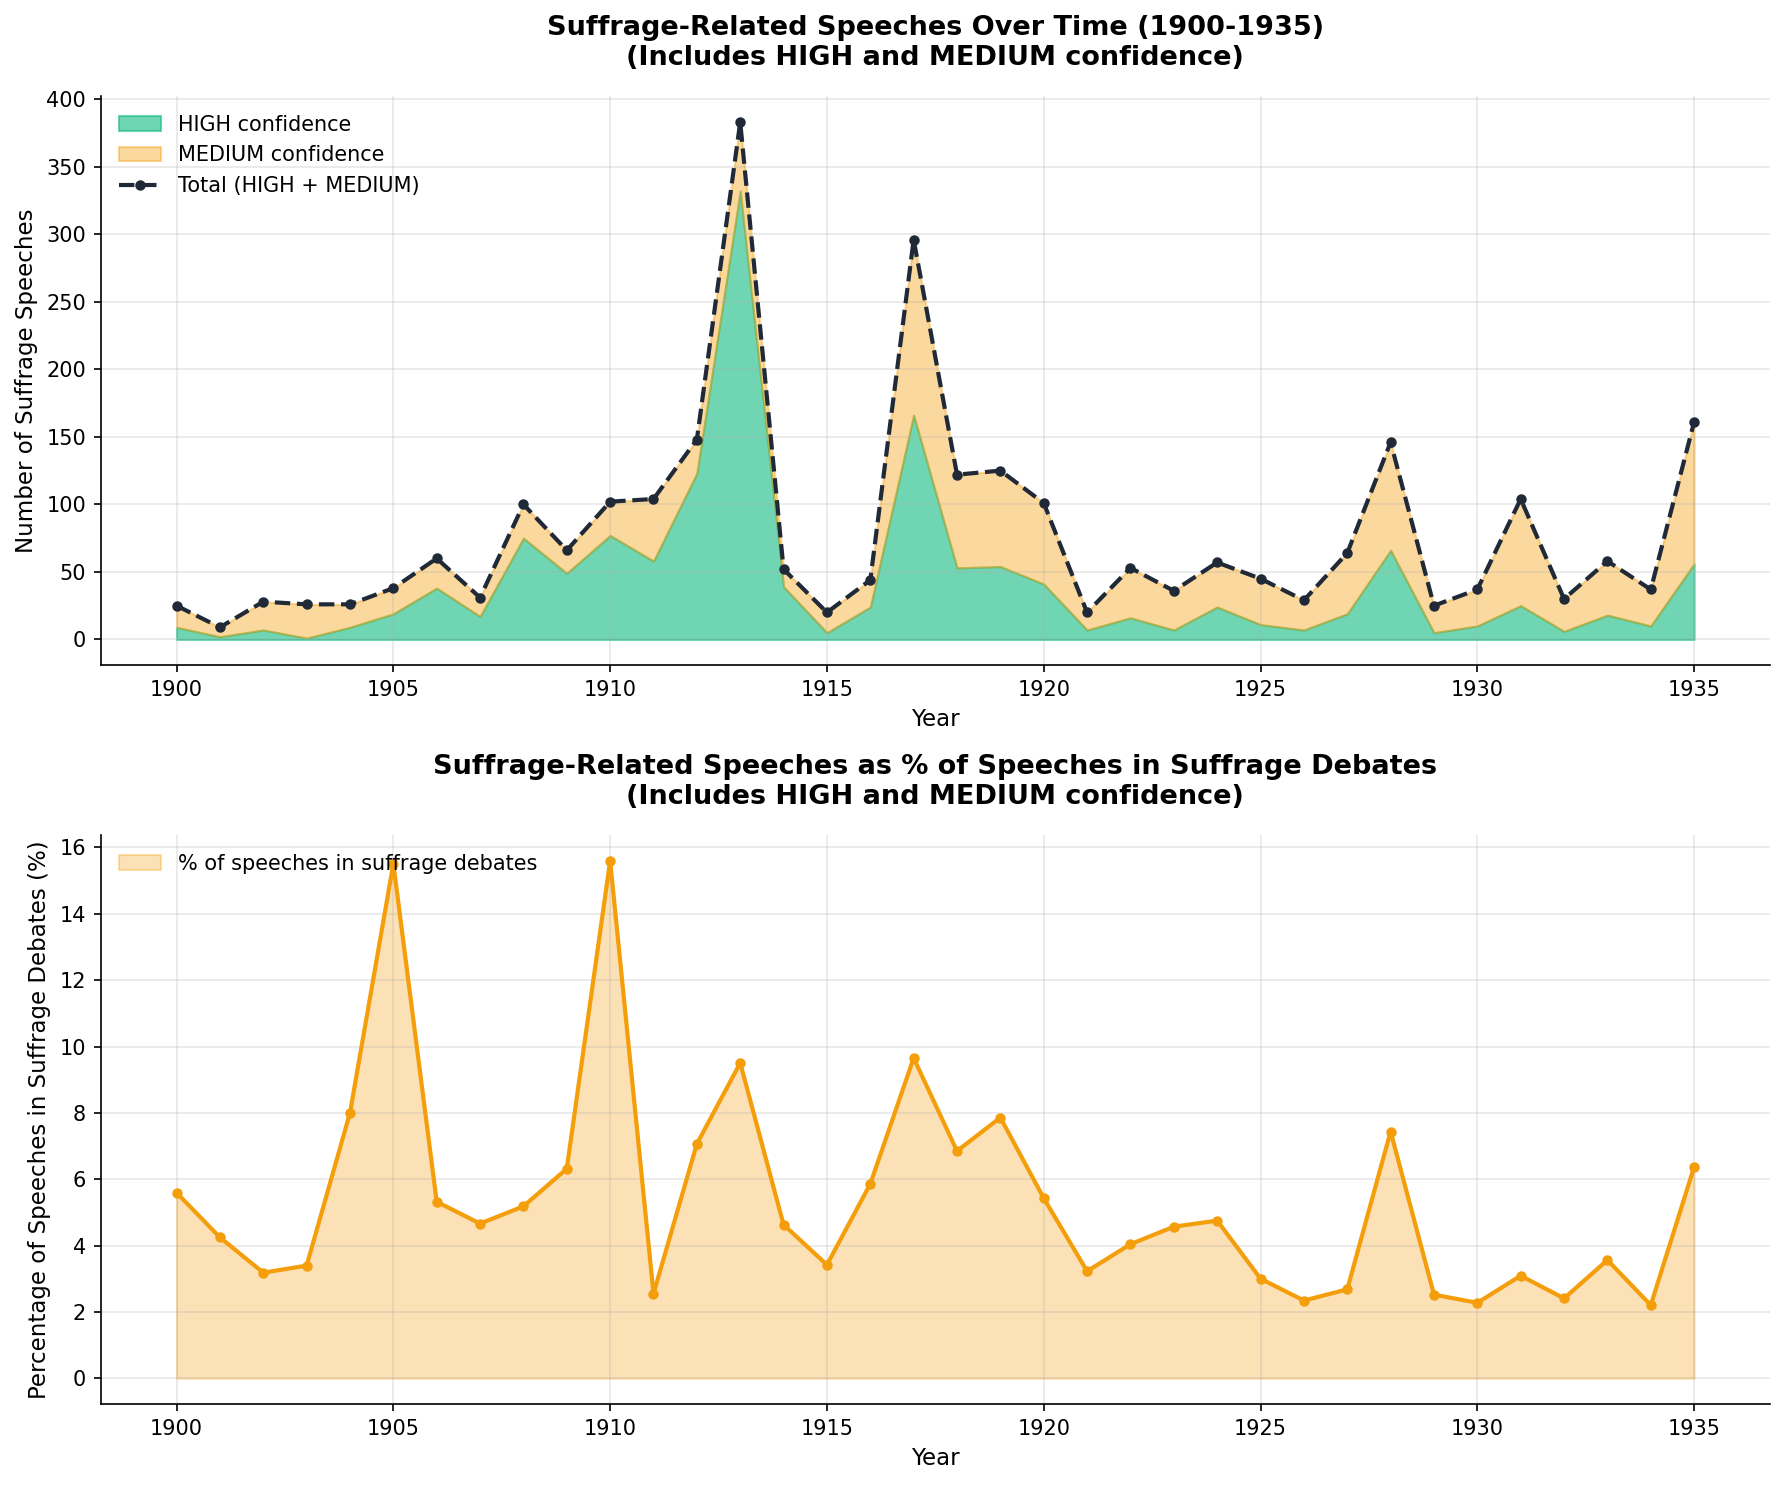

In [53]:
# Visualization 1: Suffrage speech counts over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Panel 1: Absolute counts with confidence breakdown
if 'suffrage_high' in yearly_stats.columns and 'suffrage_medium' in yearly_stats.columns:
    # Stacked area chart showing HIGH and MEDIUM confidence
    ax1.fill_between(yearly_stats.index, 0, yearly_stats['suffrage_high'], 
                      alpha=0.6, color=COLORS['accent1'], label='HIGH confidence')
    ax1.fill_between(yearly_stats.index, yearly_stats['suffrage_high'], 
                      yearly_stats['suffrage_high'] + yearly_stats['suffrage_medium'],
                      alpha=0.4, color=COLORS['accent2'], label='MEDIUM confidence')
    ax1.plot(yearly_stats.index, yearly_stats['suffrage_speeches'], 
             color=COLORS['text'], linewidth=2, marker='o', markersize=4, 
             label='Total (HIGH + MEDIUM)', linestyle='--')
else:
    # Fallback if confidence breakdown not available
    ax1.fill_between(yearly_stats.index, yearly_stats['suffrage_speeches'], 
                      alpha=0.3, color=COLORS['accent1'], label='Suffrage speeches')
    ax1.plot(yearly_stats.index, yearly_stats['suffrage_speeches'], 
             color=COLORS['accent1'], linewidth=2, marker='o', markersize=4)

ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Number of Suffrage Speeches', fontsize=11)
ax1.set_title('Suffrage-Related Speeches Over Time (1900-1935)\n(Includes HIGH and MEDIUM confidence)', 
              fontsize=13, fontweight='bold', pad=15)
ax1.legend(loc='upper left', frameon=False)
ax1.grid(True, alpha=0.3)

# Panel 2: Percentage of speeches in suffrage debates
ax2.fill_between(yearly_stats.index, yearly_stats['suffrage_pct'], 
                  alpha=0.3, color=COLORS['accent2'], label='% of speeches in suffrage debates')
ax2.plot(yearly_stats.index, yearly_stats['suffrage_pct'], 
         color=COLORS['accent2'], linewidth=2, marker='o', markersize=4)

ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Percentage of Speeches in Suffrage Debates (%)', fontsize=11)
ax2.set_title('Suffrage-Related Speeches as % of Speeches in Suffrage Debates\n(Includes HIGH and MEDIUM confidence)', 
              fontsize=13, fontweight='bold', pad=15)
ax2.legend(loc='upper left', frameon=False)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('analysis/suffrage_temporal_trends.png', dpi=300, bbox_inches='tight')
plt.show()

### Gender Participation in Suffrage Debates

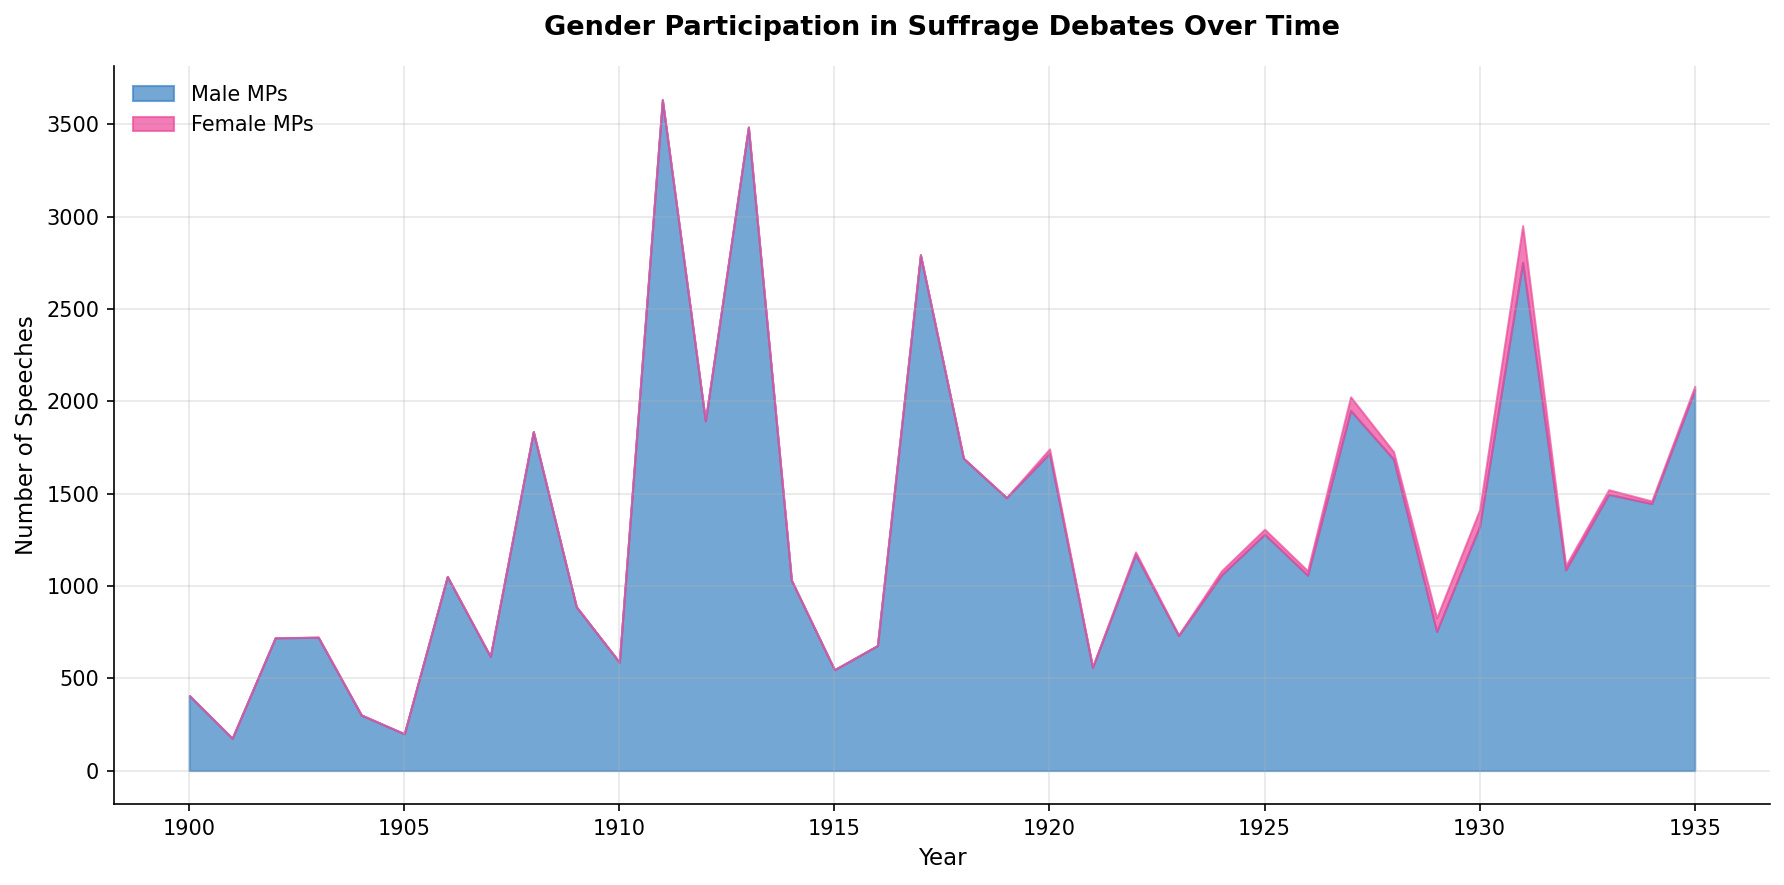


First female participation in suffrage debates: 1920
Total female speeches in suffrage debates: 672
Total male speeches in suffrage debates: 46863


In [54]:
# Gender breakdown over time
if 'gender' in speeches_df.columns and 'female_speeches' in yearly_stats.columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Stacked area chart
    ax.fill_between(yearly_stats.index, 0, yearly_stats['male_speeches'], 
                     alpha=0.7, color=COLORS['male'], label='Male MPs')
    ax.fill_between(yearly_stats.index, yearly_stats['male_speeches'], 
                     yearly_stats['male_speeches'] + yearly_stats['female_speeches'], 
                     alpha=0.7, color=COLORS['female'], label='Female MPs')
    
    ax.set_xlabel('Year', fontsize=11)
    ax.set_ylabel('Number of Speeches', fontsize=11)
    ax.set_title('Gender Participation in Suffrage Debates Over Time', fontsize=13, fontweight='bold', pad=15)
    ax.legend(loc='upper left', frameon=False, fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('analysis/suffrage_gender_participation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print first female participation
    first_female = yearly_stats[yearly_stats['female_speeches'] > 0].index.min()
    print(f"\nFirst female participation in suffrage debates: {first_female}")
    print(f"Total female speeches in suffrage debates: {yearly_stats['female_speeches'].sum():.0f}")
    print(f"Total male speeches in suffrage debates: {yearly_stats['male_speeches'].sum():.0f}")
else:
    print("Gender data not available for visualization")

## Debate Characteristics

### Most Active Debates

In [55]:
# Top debates by suffrage speech count
top_debates = debates_df.nlargest(10, 'suffrage_speeches')[[
    'date', 'total_speeches', 'suffrage_speeches', 'suffrage_pct', 'unique_speakers'
]].copy()

print("Top 10 Debates by Suffrage Speech Count:")
print("=" * 80)
print(top_debates.to_string(index=False))

Top 10 Debates by Suffrage Speech Count:
            date  total_speeches  suffrage_speeches  suffrage_pct  unique_speakers
    20 June 1917             138                 60          43.5               41
     15 May 1935             187                 50          26.7               40
   29 March 1928              64                 43          67.2               26
    19 June 1917              72                 40          55.6               31
 23 January 1913             149                 38          25.5               40
     05 May 1913              51                 37          72.5               27
 27 January 1913              86                 37          43.0               24
27 February 1920              48                 36          75.0               33
    12 July 1910              46                 32          69.6               26
15 November 1917              48                 30          62.5               24


In [63]:
# Most suffrage-focused debates (by percentage)
focused_debates = debates_df.nlargest(10, 'suffrage_pct')[[
    'date', 'total_speeches', 'suffrage_speeches', 'suffrage_pct', 'unique_speakers'
]].copy()

print("\nTop 10 Most Suffrage-Focused Debates (by percentage):")
print("=" * 80)
print(focused_debates.to_string(index=False))


Top 10 Most Suffrage-Focused Debates (by percentage):
            date  total_speeches  suffrage_speeches  suffrage_pct  unique_speakers
     02 May 1928               1                  1         100.0                1
    03 July 1906               1                  1         100.0                1
    04 July 1910               2                  2         100.0                2
  05 August 1912               1                  1         100.0                1
05 November 1908               1                  1         100.0                1
   07 April 1913               1                  1         100.0                1
  07 August 1919               1                  1         100.0                1
  08 August 1913               1                  1         100.0                1
     08 May 1905               1                  1         100.0                1
   09 April 1913               1                  1         100.0                1


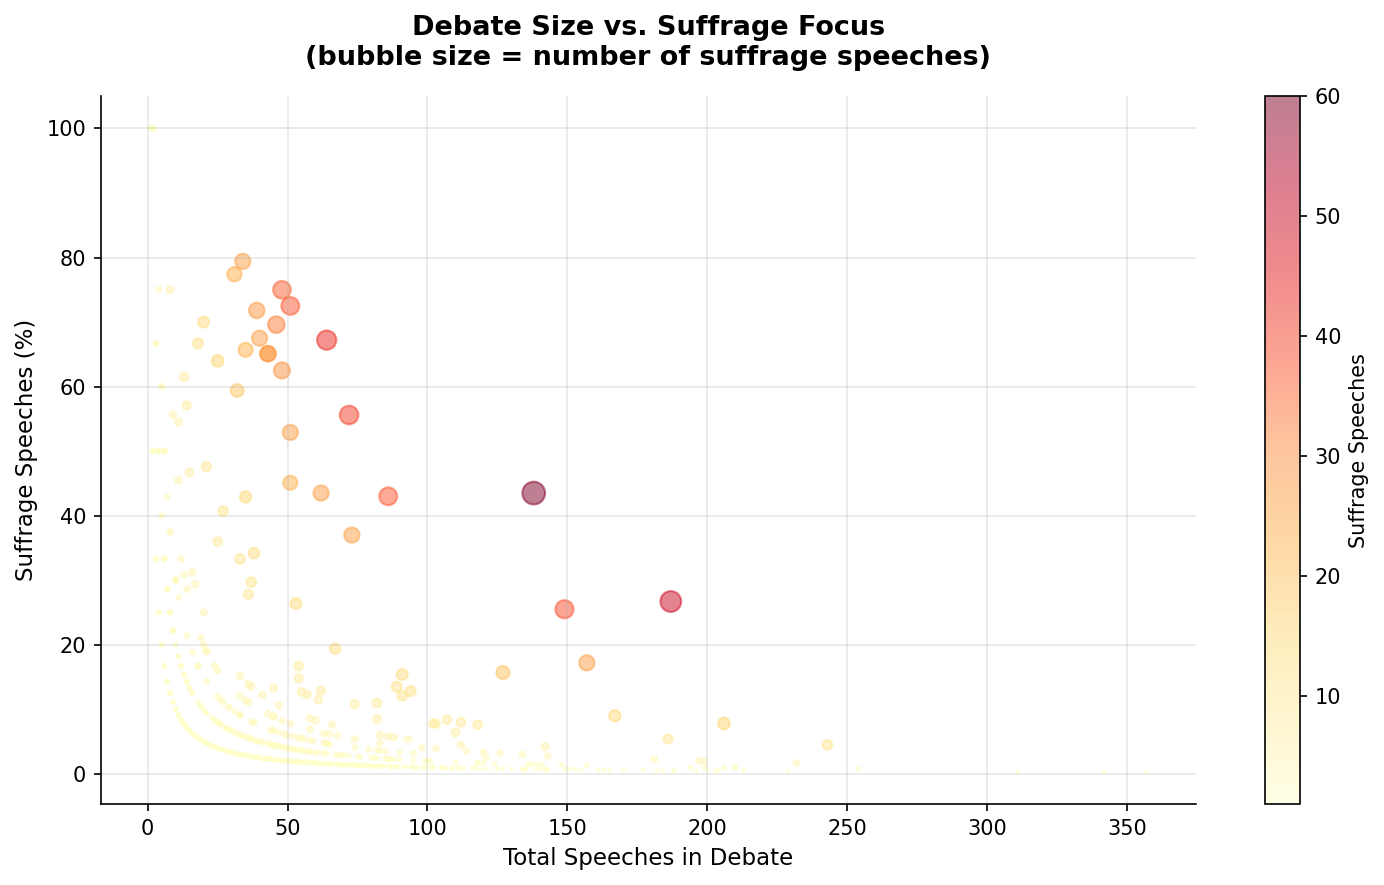

In [57]:
# Visualization: Debate size vs suffrage focus
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(debates_df['total_speeches'], 
                     debates_df['suffrage_pct'],
                     alpha=0.5, 
                     s=debates_df['suffrage_speeches']*2,
                     c=debates_df['suffrage_speeches'],
                     cmap='YlOrRd')

ax.set_xlabel('Total Speeches in Debate', fontsize=11)
ax.set_ylabel('Suffrage Speeches (%)', fontsize=11)
ax.set_title('Debate Size vs. Suffrage Focus\n(bubble size = number of suffrage speeches)', 
             fontsize=13, fontweight='bold', pad=15)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Suffrage Speeches', fontsize=10)

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('analysis/suffrage_debate_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

## Speech Length Analysis

In [64]:
# Compare speech lengths
if 'text' in speeches_df.columns:
    # Only calculate word_count if it doesn't already exist
    if 'word_count' not in speeches_df.columns or speeches_df['word_count'].isna().all():
        speeches_df['word_count'] = speeches_df['text'].str.split().str.len()
    
    suffrage_lengths = speeches_df[speeches_df['is_suffrage_speech']]['word_count'].dropna()
    non_suffrage_lengths = speeches_df[~speeches_df['is_suffrage_speech']]['word_count'].dropna()
    
    print("Speech Length Statistics:")
    print("=" * 60)
    print(f"\nSuffrage speeches:")
    print(f"  Mean: {suffrage_lengths.mean():.1f} words")
    print(f"  Median: {suffrage_lengths.median():.1f} words")
    print(f"  Std: {suffrage_lengths.std():.1f} words")
    
    print(f"\nNon-suffrage speeches:")
    print(f"  Mean: {non_suffrage_lengths.mean():.1f} words")
    print(f"  Median: {non_suffrage_lengths.median():.1f} words")
    print(f"  Std: {non_suffrage_lengths.std():.1f} words")

Speech Length Statistics:

Suffrage speeches:
  Mean: 1091.9 words
  Median: 743.5 words
  Std: 1161.9 words

Non-suffrage speeches:
  Mean: 431.5 words
  Median: 135.0 words
  Std: 706.0 words


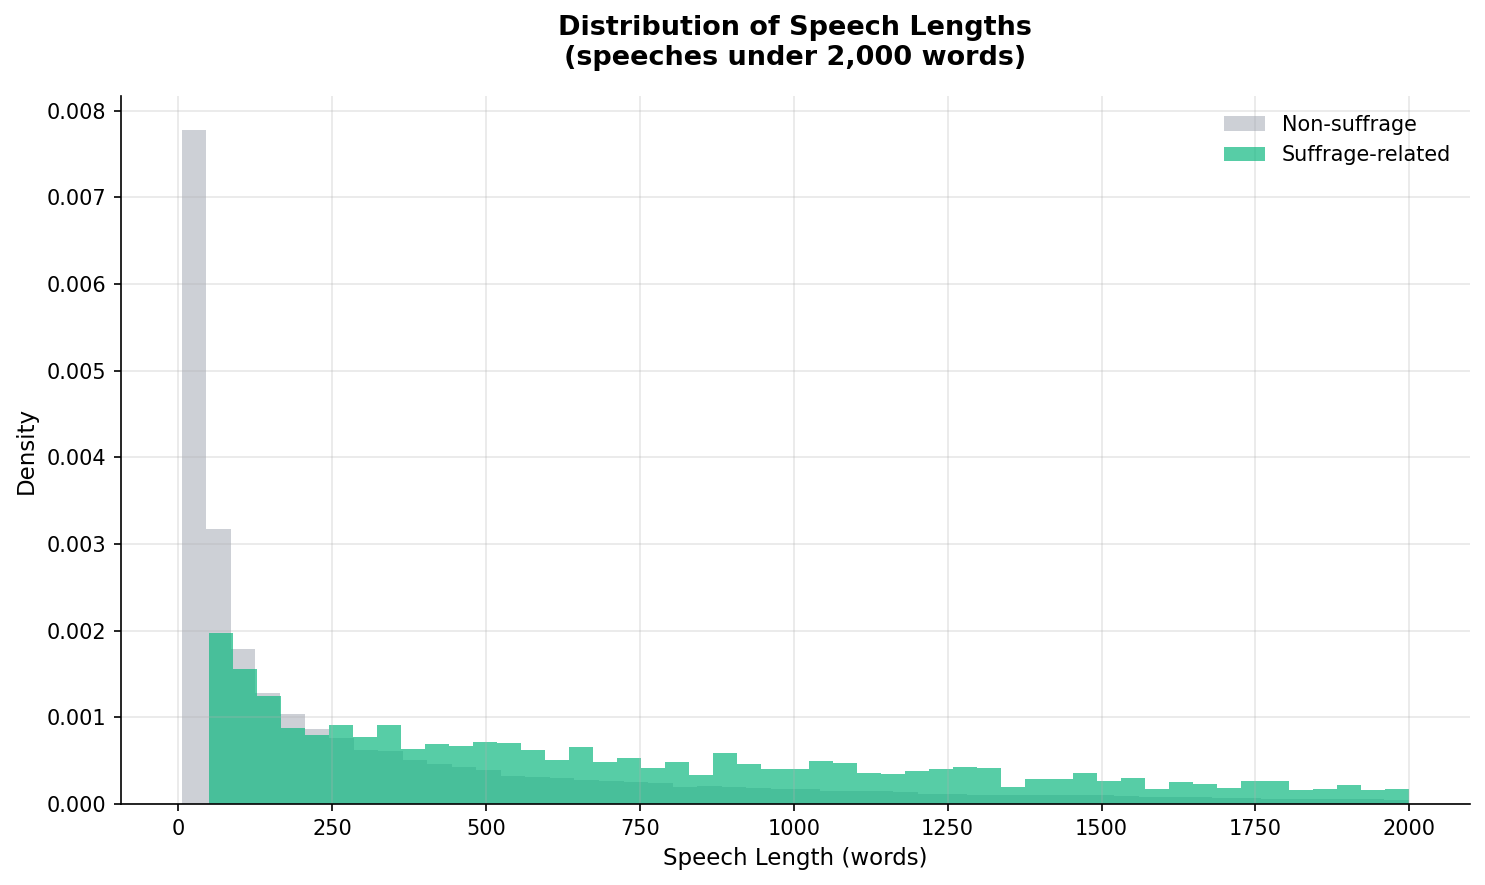

In [59]:
# Visualization: Speech length distributions
if 'word_count' in speeches_df.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Use only speeches under 2000 words for clearer visualization
    suffrage_plot = suffrage_lengths[suffrage_lengths < 2000]
    non_suffrage_plot = non_suffrage_lengths[non_suffrage_lengths < 2000]
    
    ax.hist(non_suffrage_plot, bins=50, alpha=0.5, label='Non-suffrage', 
            color=COLORS['muted'], density=True)
    ax.hist(suffrage_plot, bins=50, alpha=0.7, label='Suffrage-related', 
            color=COLORS['accent1'], density=True)
    
    ax.set_xlabel('Speech Length (words)', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title('Distribution of Speech Lengths\n(speeches under 2,000 words)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.legend(loc='upper right', frameon=False, fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('analysis/suffrage_speech_lengths.png', dpi=300, bbox_inches='tight')
    plt.show()

## Key Historical Moments

Let's examine debates around key suffrage milestones:

In [65]:
# Key years in suffrage history
key_years = {
    1913: 'Cat and Mouse Act',
    1918: 'Representation of the People Act (women 30+)',
    1928: 'Equal Franchise Act (women 21+)',
}

print("Suffrage Activity Around Key Historical Moments:")
print("=" * 80)

for year, event in key_years.items():
    if year in yearly_stats.index:
        stats = yearly_stats.loc[year]
        print(f"\n{year}: {event}")
        print(f"  Total speeches: {stats['total_speeches']:.0f}")
        print(f"  Suffrage speeches: {stats['suffrage_speeches']:.0f} ({stats['suffrage_pct']:.1f}%)")
        if 'female_speeches' in stats:
            print(f"  Female participation: {stats['female_speeches']:.0f} speeches")

Suffrage Activity Around Key Historical Moments:

1913: Cat and Mouse Act
  Total speeches: 4030
  Suffrage speeches: 383 (9.5%)
  Female participation: 0 speeches

1918: Representation of the People Act (women 30+)
  Total speeches: 1781
  Suffrage speeches: 122 (6.9%)
  Female participation: 0 speeches

1928: Equal Franchise Act (women 21+)
  Total speeches: 1963
  Suffrage speeches: 146 (7.4%)
  Female participation: 40 speeches


In [61]:
# Debates in key years
debates_df['year'] = pd.to_datetime(debates_df['date']).dt.year

for year, event in key_years.items():
    year_debates = debates_df[debates_df['year'] == year].nlargest(5, 'suffrage_speeches')
    if len(year_debates) > 0:
        print(f"\nTop debates in {year} ({event}):")
        print(year_debates[['date', 'total_speeches', 'suffrage_speeches', 'suffrage_pct']].to_string(index=False))
        print()


Top debates in 1913 (Cat and Mouse Act):
           date  total_speeches  suffrage_speeches  suffrage_pct
23 January 1913             149                 38          25.5
    05 May 1913              51                 37          72.5
27 January 1913              86                 37          43.0
    06 May 1913              39                 28          71.8
  02 April 1913              73                 27          37.0


Top debates in 1918 (Representation of the People Act (women 30+)):
            date  total_speeches  suffrage_speeches  suffrage_pct
 23 October 1918              25                 16          64.0
06 November 1918              33                 11          33.3
04 November 1918              21                 10          47.6
    09 July 1918              55                  7          12.7
     02 May 1918              47                  5          10.6


Top debates in 1928 (Equal Franchise Act (women 21+)):
            date  total_speeches  suffrage_sp

## Summary Statistics Table

In [66]:
# Create comprehensive summary
summary = {
    'Metric': [
        'Total Debates',
        'Total Speeches',
        'Suffrage Speeches',
        'High Confidence Suffrage',
        'Medium Confidence Suffrage',
        'MP Match Rate',
        'Date Range',
        'Peak Year (by count)',
        'Peak Year (by %)',
    ],
    'Value': [
        f"{len(debates_df):,}",
        f"{len(speeches_df):,}",
        f"{speeches_df['is_suffrage_speech'].sum():,} ({speeches_df['is_suffrage_speech'].mean()*100:.1f}%)",
        f"{(speeches_df['suffrage_confidence'] == 'HIGH').sum():,}",
        f"{(speeches_df['suffrage_confidence'] == 'MEDIUM').sum():,}",
        f"{speeches_df['matched_mp'].mean()*100:.1f}%",
        f"{speeches_df['date'].min().strftime('%b %Y')} - {speeches_df['date'].max().strftime('%b %Y')}",
        f"{yearly_stats['suffrage_speeches'].idxmax()} ({yearly_stats['suffrage_speeches'].max():.0f} speeches)",
        f"{yearly_stats['suffrage_pct'].idxmax()} ({yearly_stats['suffrage_pct'].max():.1f}%)",
    ]
}

summary_df = pd.DataFrame(summary)
print("\n" + "=" * 80)
print("DATASET SUMMARY")
print("=" * 80)
print(summary_df.to_string(index=False))


DATASET SUMMARY
                    Metric               Value
             Total Debates               1,221
            Total Speeches              53,339
         Suffrage Speeches        2,808 (5.3%)
  High Confidence Suffrage               1,485
Medium Confidence Suffrage               1,323
             MP Match Rate               89.1%
                Date Range Feb 1900 - Dec 1935
      Peak Year (by count) 1913 (383 speeches)
          Peak Year (by %)        1910 (15.6%)


## Conclusions

This dataset provides comprehensive coverage of suffrage-related parliamentary debates from 1900-1935, capturing:

1. **Peak activity** around key legislative moments (1913, 1917-1918, 1928)
2. **High-quality matching** with 89% of speeches linked to MPs
3. **Gender participation** tracking the entry of women MPs after 1918
4. **Debate context** including both suffrage-specific and related discussions

The validated suffrage speech detection ensures high confidence in the relevance of the extracted content.